# PyDMD

## Tutorial 7: Dynamic mode decomposition with control

In this tutorial we will show how to extend the dynamic mode decomposition to incorporate the effect of control (this technique has been introduced in the paper [Dynamic mode decomposition with control](https://arxiv.org/abs/1409.6358)).

First of all we import the `DMDc` class from the pydmd package, we set matplotlib for the notebook and we import numpy and scipy.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy

from pydmd import DMDc
from pydmd.plotter import plot_eigs

Now, we create our dataset: since we want to add the control, the evolution of the complex system can be formally summarized as:
$$
\mathbf{x}_{k+1} = \mathbf{A}\mathbf{x}_k + \mathbf{B}\mathbf{u}_k,
$$where the operators $\mathbf{A}$ and $\mathbf{B}$ are the ones we will approximate using DMD. So, for a demostrative purpose, we create the original snapshots by using two random operators.

In [2]:
def create_system(n, m):
    A = scipy.linalg.helmert(n, True)
    B = np.random.rand(n, n)-.5
    x0 = np.array([0.25]*n)
    u = np.random.rand(n, m-1)-.5
    snapshots = [x0]
    for i in range(m-1):
        snapshots.append(A.dot(snapshots[i])+B.dot(u[:, i]))
    snapshots = np.array(snapshots).T
    return {'snapshots': snapshots, 'u': u, 'B': B, 'A': A}

We got 10 snapshots of the evolving system.

In [3]:
s = create_system(25, 10)
print(s['snapshots'].shape)

(25, 10)


Now, we can compute as usually the DMD algorithm on the data: the `fit` method in this version take as arguments the snapshots and the control input (the $\mathbf{B}$ operator can be also passed). In this case, we do not perform any truncation.

In [4]:
dmdc = DMDc(svd_rank=-1)
dmdc.fit(s['snapshots'], s['u'])

Let us visualize the original system and the reconstructed one: also because without truncation, the plots are the same!

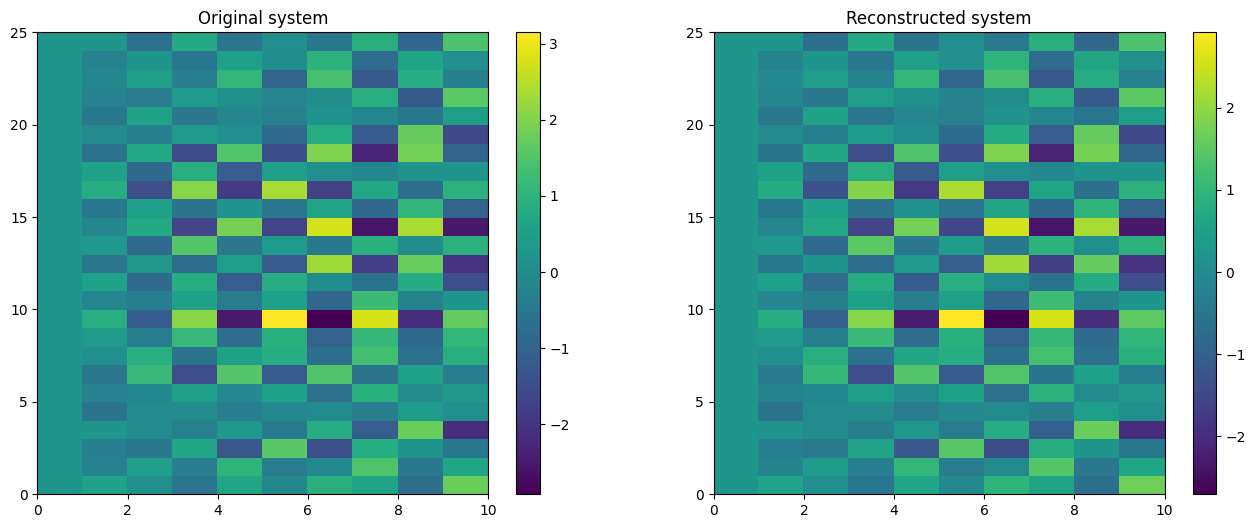

In [5]:
plt.figure(figsize=(16, 6))

plt.subplot(121)
plt.title('Original system')
plt.pcolor(s['snapshots'].real)
plt.colorbar()

plt.subplot(122)
plt.title('Reconstructed system')
plt.pcolor(dmdc.reconstructed_data().real)
plt.colorbar()

plt.show()

Well, we built the approximation for $\mathbf{A}$ and for $\mathbf{B}$; we can now test the system with a different control input: differently by the other versions, we can pass as argument of the `reconstructed_data` method the control input we want to test.

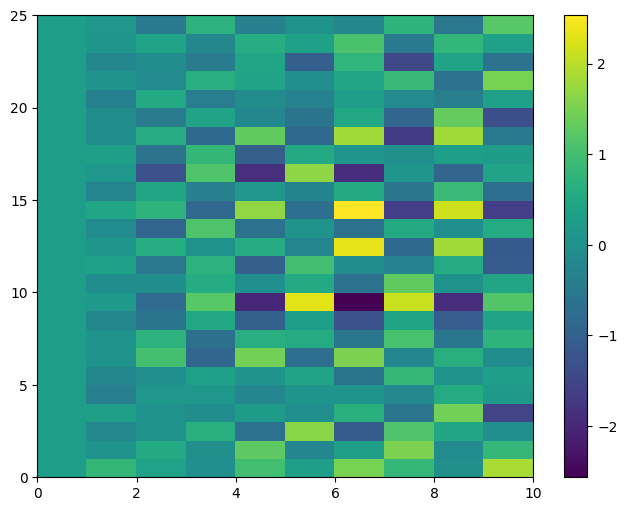

In [6]:
new_u = np.exp(s['u'])

plt.figure(figsize=(8, 6))
plt.pcolor(dmdc.reconstructed_data(new_u).real)
plt.colorbar()
plt.show()

Finally, we can also use a different timestep for the reconstruction, obviously passing the proper control input (the number of inputs we pass has to be the number of reconstructed snapshots we try to compute, except for the first snapshots). We continue halving the timestep and create a new random input.

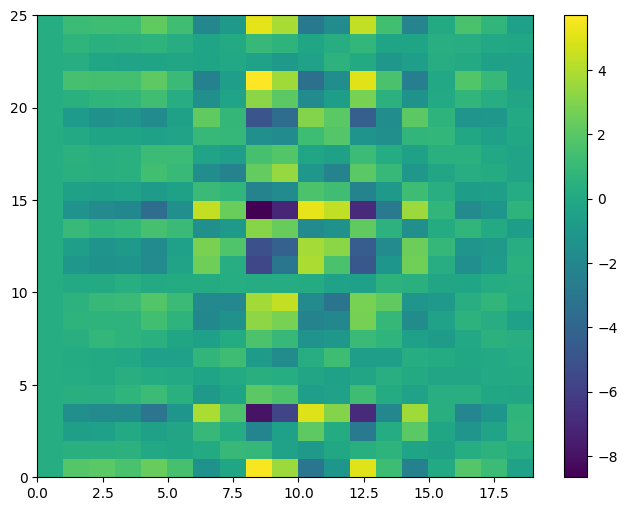

In [7]:
dmdc.dmd_time['dt'] = .5
new_u = np.random.rand(s['u'].shape[0], dmdc.dynamics.shape[1]-1)

plt.figure(figsize=(8, 6))
plt.pcolor(dmdc.reconstructed_data(new_u).real)
plt.colorbar()
plt.show()

## Recovering unstable dynamics

In this subsection of the `DMDc` tutorial we are going to investigate the stabilizing effect of control in an unstable linear system. For simplicity we consider a 3D system with a known `B` operator. This tutorial is inspired by `Example 1` in the paper [Dynamic mode decomposition with control](https://arxiv.org/abs/1409.6358).

In [8]:
time_instants = 5

A = np.array([[2.1, 0, 0], [0, 0.5, 0], [0, 0, 6.9]])
B = np.array([1.3 , 0, 3])[:, None] * 2

snapshots = np.zeros((3, time_instants))
snapshots[:, 0] = np.array([5, 6, 3])

We construct our snapshots matrix using the usual formula: $\mathbf{x}_{k+1} = \mathbf{A}\mathbf{x}_k + \mathbf{B}\mathbf{u}_k$, where `A`,`B` are specified above, and $\mathbf{u}_k = -\mathbf{x}_k$.

In [9]:
for i in range(1, time_instants):
    previous_snapshot = snapshots[:, i-1][:, None]
    snapshots[:, i] = (A.dot(previous_snapshot) - B*previous_snapshot).flatten()
print(snapshots)

[[ 5.     -2.5     1.25   -0.625   0.3125]
 [ 6.      3.      1.5     0.75    0.375 ]
 [ 3.      2.7     2.43    2.187   1.9683]]


We construct the control input matrix used in the formula, in order to feed it to the `DMDc` constructor:

In [10]:
I = -snapshots[:, :-1]
print(I)

dmdc = DMDc(svd_rank=-1).fit(snapshots, I, np.diag(B.flatten()))

[[-5.     2.5   -1.25   0.625]
 [-6.    -3.    -1.5   -0.75 ]
 [-3.    -2.7   -2.43  -2.187]]


We now pause `DMDc` for one moment, and analyze the system resulting from the set of snapshots, as if we did not know that it is a control system. Therefore we use the standard DMD algorithm, and then plot the eigenvalues to assess the stability of its dynamics.

/Users/francescoandreuzzi/code/units/PyDMD/pydmd/plotter.py:185: UserWarning: Legend does not support handles for list instances.
A proxy artist may be used instead.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#controlling-the-legend-entries
  plt.legend(


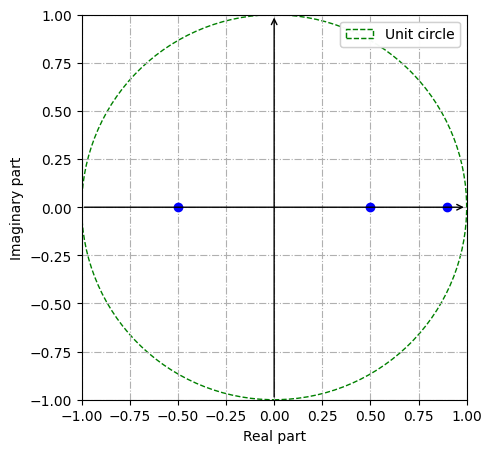

In [11]:
from pydmd import DMD
dmd = DMD(svd_rank=-1)
dmd.fit(snapshots)
plot_eigs(dmd, show_axes=True, show_unit_circle=True, figsize=(5, 5), filename='eigs_ex1.pdf')

As we can see the eigenvalues are all inside the unit sphere, therefore the corresponding dynamics are all stable. 

By contrast, if we use DMD with control we see that there are some unstable dynamics in the "real" `A` operator, which we lose when we use the original algorithm, but are recovered if we employ the modified one.

/Users/francescoandreuzzi/code/units/PyDMD/pydmd/plotter.py:185: UserWarning: Legend does not support handles for list instances.
A proxy artist may be used instead.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#controlling-the-legend-entries
  plt.legend(


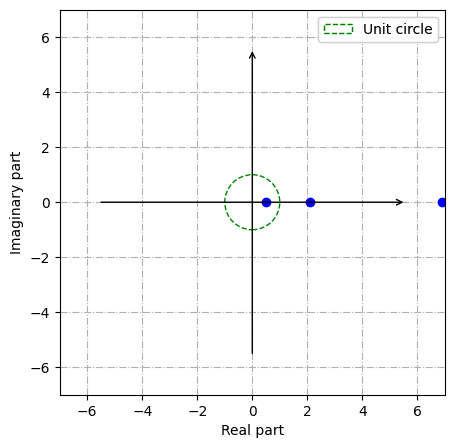

Eigenvalue 6.900000000000041: distance from unit circle 5.900000000000041
Eigenvalue 0.49999999999999917: distance from unit circle 0.5000000000000009
Eigenvalue 2.0999999999999948: distance from unit circle 1.0999999999999948


In [12]:
plot_eigs(dmdc, show_axes=True, show_unit_circle=True, figsize=(5, 5))

for eig in dmdc.eigs:
    print('Eigenvalue {}: distance from unit circle {}'.format(eig, np.abs(1-np.linalg.norm(eig))))

We seek a confirmation about this fact by computing the eigenvalues of the operator `A` which we used when we constructed the system, and we compare them with the eigenvalues of `dmd.atilde` which holds the approximation of `A` built by DMD with control.

In [14]:
print('Eigenvalues of A:', np.linalg.eigvals(A), '; eigenvalues of A_tilde: ', 
      np.linalg.eigvals(dmdc.operator.as_numpy_array))

Eigenvalues of A: [2.1 0.5 6.9] ; eigenvalues of A_tilde:  [6.9 0.5 2.1]
